# Illinois Saptial AutoCorrelation Analysis
Lets take a deep dive into the correlation between the geolocation of gun violence incidents and the Illinois census tract data. Is there a correlation between the locations of incidents throughout the state of Illinois?

We will now install the libraries needed to read/wrangle data, create spacial data, analyze Moran's number, and to create graphics.

In [51]:
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

import osmnx as ox
import pandas as pd

## Import First Data Set

Import illinois data of gun violence related incidents

In [8]:
gvIllinois = gpd.read_file('cleanGunDataIllinois.csv')

Extract the geospatial aspect of the gun violence data into columns with the latitude and longitude

In [9]:
gvIllinois = gvIllinois[[
 'latitude',
 'longitude']]
gvIllinois

,latitude,longitude
0,41.7592,-87.5628
1,41.7358,-87.6631
2,41.7906,-87.6418
3,39.5417,-90.3301
4,41.8968,-87.7556
...,...,...
17551,42.2523,-89.0864
17552,,
17553,,
17554,41.7286,-87.6425


convert the pandas strings data type of the long. and lat. to floats

In [10]:
gvIllinois['latitude'] = pd.to_numeric(gvIllinois['latitude'],errors='coerce')
gvIllinois['longitude'] = pd.to_numeric(gvIllinois['longitude'],errors='coerce')

convert the gun violence data from pandas to geopandas dataframe

In [11]:
gvIllinois = gpd.GeoDataFrame(gvIllinois, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(gvIllinois.longitude, gvIllinois.latitude))

project data onto a mercator map

In [12]:
gvIllinois = gvIllinois.to_crs(epsg=3857)

## Important Illinois Population Census Data
Import the census tract record of population in Illinois

In [25]:
illinoisPop = gpd.read_file('illinoisPop.geojson')

Remove the first row of the data frame that includes Illinois total accumilation of population so it doesn't skew the data

In [26]:
illinoisPop = illinoisPop.drop([0])

Check to see if the row was dropped

In [27]:
illinoisPop.head()

,geoid,name,B01003001,"B01003001, Error",geometry
1,14000US17001000100,"Census Tract 1, Adams, IL",4761.0,340.0,"MULTIPOLYGON (((-91.37766 39.94285, -91.37766 ..."
2,14000US17001000201,"Census Tract 2.01, Adams, IL",1985.0,166.0,"MULTIPOLYGON (((-91.39655 39.95078, -91.39654 ..."
3,14000US17001000202,"Census Tract 2.02, Adams, IL",2376.0,246.0,"MULTIPOLYGON (((-91.39369 39.94311, -91.39369 ..."
4,14000US17001000400,"Census Tract 4, Adams, IL",3422.0,440.0,"MULTIPOLYGON (((-91.42005 39.95081, -91.41917 ..."
5,14000US17001000500,"Census Tract 5, Adams, IL",2175.0,239.0,"MULTIPOLYGON (((-91.40341 39.94942, -91.40340 ..."


Trim down the columns 

In [28]:
list(illinoisPop)
columns_to_keep = ['geoid',
'name',
'B01003001',
'geometry']
illinoisPop = illinoisPop[columns_to_keep]

Rename the columns so they are usable and check

In [29]:
illinoisPop.columns = ['geoid',
 'name',
 'Total',
 'geometry']
illinoisPop.head()

,geoid,name,Total,geometry
1,14000US17001000100,"Census Tract 1, Adams, IL",4761.0,"MULTIPOLYGON (((-91.37766 39.94285, -91.37766 ..."
2,14000US17001000201,"Census Tract 2.01, Adams, IL",1985.0,"MULTIPOLYGON (((-91.39655 39.95078, -91.39654 ..."
3,14000US17001000202,"Census Tract 2.02, Adams, IL",2376.0,"MULTIPOLYGON (((-91.39369 39.94311, -91.39369 ..."
4,14000US17001000400,"Census Tract 4, Adams, IL",3422.0,"MULTIPOLYGON (((-91.42005 39.95081, -91.41917 ..."
5,14000US17001000500,"Census Tract 5, Adams, IL",2175.0,"MULTIPOLYGON (((-91.40341 39.94942, -91.40340 ..."


delete rows that have less than a 100 population geographies

In [30]:
illinoisPop = illinoisPop[illinoisPop['Total']>100]

project data onto a mercator map so it matches the gun violence data

In [31]:
illinoisPop = illinoisPop.to_crs(epsg=3857)

## Spatial Join

Now we will be doing a spatial join of the Illinois population data and the gun violence data. We will be attaching the gun violence data to the population data

In [32]:
join = gpd.sjoin(gvIllinois, illinoisPop, how='left')
join.head()

,latitude,longitude,geometry,index_right,geoid,name,Total
0,41.7592,-87.5628,POINT (-9747446.308 5124976.743),594.0,14000US17031431302,"Census Tract 4313.02, Cook, IL",4329.0
1,41.7358,-87.6631,POINT (-9758611.653 5121485.357),792.0,14000US17031711200,"Census Tract 7112, Cook, IL",4949.0
2,41.7906,-87.6418,POINT (-9756240.548 5129663.767),1379.0,14000US17031834700,"Census Tract 8347, Cook, IL",1258.0
3,39.5417,-90.3301,POINT (-10055500.735 4799565.173),2749.0,14000US17171970700,"Census Tract 9707, Scott, IL",3261.0
4,41.8968,-87.7556,POINT (-9768908.706 5145533.098),459.0,14000US17031251100,"Census Tract 2511, Cook, IL",4811.0


This counts gun violence rates by their corresponding census group in the pop. data, we will be using geoid as a geographic reference

In [33]:
gvIllinois_by_illinoisPop = join.geoid.value_counts().rename_axis('geoid').reset_index(name='gvIllinois_count')

print to check

In [34]:
gvIllinois_by_illinoisPop.head()

,geoid,gvIllinois_count
0,14000US17031231500,122
1,14000US17031251800,104
2,14000US17031252102,98
3,14000US17143000300,94
4,14000US17031252202,91


this is a barchart of the top 20 block groups with the largest amount of gun violence incidents

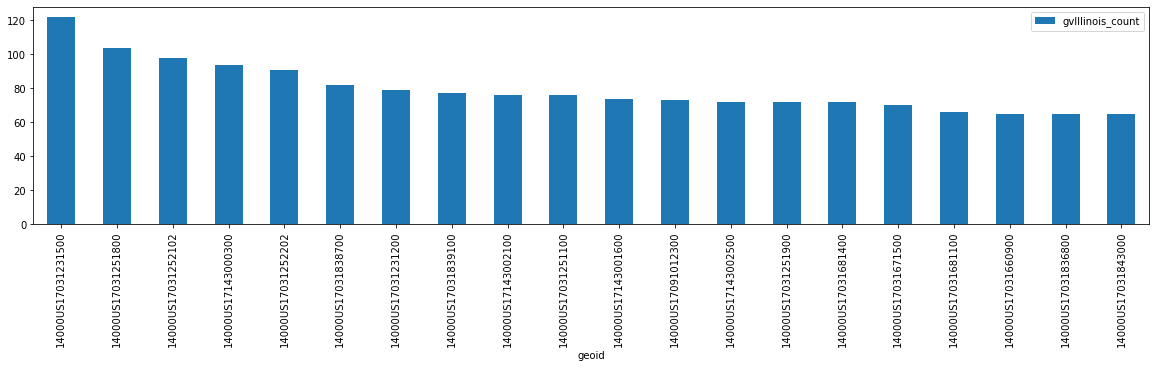

In [35]:
gvIllinois_by_illinoisPop[:20].plot.bar(figsize=(20,4),
                             x='geoid',
                             y='gvIllinois_count')

now we will join the summary table back to the pop. data

In [36]:
illinoisPop = illinoisPop.merge(gvIllinois_by_illinoisPop,on='geoid')

and check again

In [37]:
illinoisPop.head()

,geoid,name,Total,geometry,gvIllinois_count
0,14000US17001000100,"Census Tract 1, Adams, IL",4761.0,"MULTIPOLYGON (((-10172114.915 4857640.724, -10...",2
1,14000US17001000201,"Census Tract 2.01, Adams, IL",1985.0,"MULTIPOLYGON (((-10174217.629 4858791.758, -10...",1
2,14000US17001000202,"Census Tract 2.02, Adams, IL",2376.0,"MULTIPOLYGON (((-10173899.478 4857678.330, -10...",1
3,14000US17001000400,"Census Tract 4, Adams, IL",3422.0,"MULTIPOLYGON (((-10176832.969 4858796.550, -10...",15
4,14000US17001000500,"Census Tract 5, Adams, IL",2175.0,"MULTIPOLYGON (((-10174981.503 4858594.707, -10...",6


normalize the data and add a new column for the number of gun violence incidents per 1000

In [38]:
illinoisPop['gvIllinois_per_1000'] = illinoisPop['gvIllinois_count']/illinoisPop['Total']*1000

check again!

In [39]:
illinoisPop.sort_values(by="gvIllinois_per_1000").tail()

,geoid,name,Total,geometry,gvIllinois_count,gvIllinois_per_1000
388,14000US17031270500,"Census Tract 2705, Cook, IL",1271.0,"MULTIPOLYGON (((-9765038.016 5143138.758, -976...",46,36.191975
396,14000US17031280800,"Census Tract 2808, Cook, IL",786.0,"MULTIPOLYGON (((-9761773.683 5143187.351, -976...",29,36.895674
647,14000US17031671400,"Census Tract 6714, Cook, IL",1147.0,"MULTIPOLYGON (((-9760359.035 5127538.500, -976...",46,40.104621
1038,14000US17031834700,"Census Tract 8347, Cook, IL",1258.0,"MULTIPOLYGON (((-9757155.149 5130207.252, -975...",51,40.540541
1633,14000US17143000300,"Census Tract 3, Peoria, IL",1698.0,"MULTIPOLYGON (((-9977889.232 4963374.776, -997...",94,55.359246


We will now be using the KNN library and we will set k=8 to account for surrounding neighbors to determine the spatial weight of gun violence in Illinois. Then we do row standardization to adjust the nearest neighbor weight in a spatial weight matrix

In [40]:
wq = lps.weights.KNN.from_dataframe(illinoisPop,k=8)
wq.transform = 'r'

We will now be creating a new column for the average of the “r” value to create a single value

In [41]:
illinoisPop['gvIllinois_per_1000_lag'] = lps.weights.lag_spatial(wq, illinoisPop['gvIllinois_per_1000'])

create new column that calculates the difference between gun violence data and spatial lag

In [42]:
illinoisPop['gvIllinois_lag_diff'] = illinoisPop['gvIllinois_per_1000'] - illinoisPop['gvIllinois_per_1000_lag']


check the first and last 5 rows

In [43]:
illinoisPop.sort_values(by='gvIllinois_lag_diff')

,geoid,name,Total,geometry,gvIllinois_count,gvIllinois_per_1000,gvIllinois_per_1000_lag,gvIllinois_lag_diff
1824,14000US17179020400,"Census Tract 204, Tazewell, IL",5360.0,"MULTIPOLYGON (((-9976691.879 4958637.297, -997...",4,0.746269,22.959926,-22.213658
1670,14000US17143004802,"Census Tract 48.02, Peoria, IL",4197.0,"MULTIPOLYGON (((-9983165.998 4961739.553, -998...",7,1.667858,22.506189,-20.838331
1669,14000US17143004801,"Census Tract 48.01, Peoria, IL",4661.0,"MULTIPOLYGON (((-9989770.806 4962003.242, -998...",4,0.858185,19.202132,-18.343947
1821,14000US17179020100,"Census Tract 201, Tazewell, IL",2485.0,"MULTIPOLYGON (((-9976014.945 4962473.704, -997...",3,1.207243,19.489096,-18.281853
380,14000US17031260300,"Census Tract 2603, Cook, IL",1668.0,"MULTIPOLYGON (((-9766695.007 5144198.881, -976...",18,10.791367,26.200791,-15.409424
...,...,...,...,...,...,...,...,...
393,14000US17031271800,"Census Tract 2718, Cook, IL",730.0,"MULTIPOLYGON (((-9762832.109 5142086.078, -976...",26,35.616438,14.948661,20.667778
1356,14000US17091011600,"Census Tract 116, Kankakee, IL",1482.0,"MULTIPOLYGON (((-9781092.736 5030710.056, -978...",40,26.990553,4.789948,22.200606
396,14000US17031280800,"Census Tract 2808, Cook, IL",786.0,"MULTIPOLYGON (((-9761773.683 5143187.351, -976...",29,36.895674,14.044689,22.850986
647,14000US17031671400,"Census Tract 6714, Cook, IL",1147.0,"MULTIPOLYGON (((-9760359.035 5127538.500, -976...",46,40.104621,17.204441,22.900179


## Moran Plot

Now we will quantify the degree of the spatial correlations using Moran's Plot

In [44]:
y = illinoisPop.gvIllinois_per_1000
moran = Moran(y, wq)
moran.I

0.6907841838799409

It seems our Moran value is 0.69 which is a high positive value which means there is a positive spatial autocorrelation. Which means like values are close to like values (ex/ low incident rate areas are close to other low incident rate areas)


now we output a scatter plot of our "gun violence data per 1000" and "gun violence data per 1000 spatial lag" in Illinois

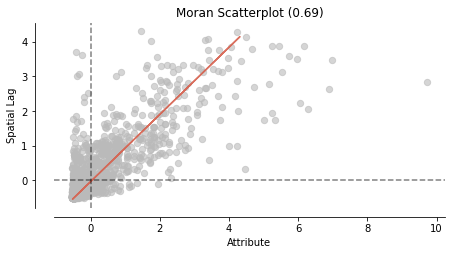

In [45]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

We will now compare our observed Moran’s I value to this reference distribution

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7c8cec9cd0>)

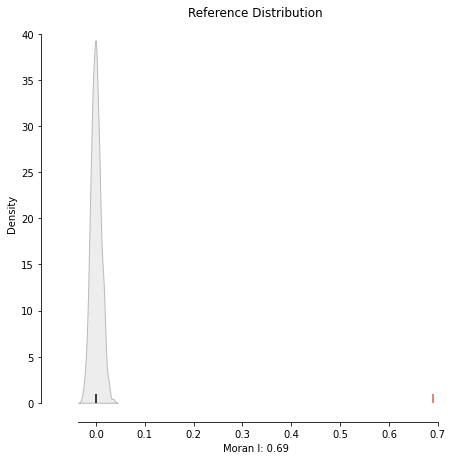

In [46]:
plot_moran_simulation(moran,aspect_equal=False)

In [47]:
moran.p_sim

0.001

Looking at the distribution above and the calculated P value of 0.001, we can determine that only 0.1% of Moran’s statistic would be larger than the onee calculator (0.69). Proving that the correlation is high enough to be predictable.

calculate local moran values

In [48]:
lisa = esda.moran.Moran_Local(y, wq)

now we plot and add some arguments for the labels for our moran local scatterplot. using lisa to detect clusters for the correlation in neighborhood quality and our gun data, we can discern the high values near to high values (HH), low values with nearby low values (LL), low values with high values in its neighborhood (& vice-versa)

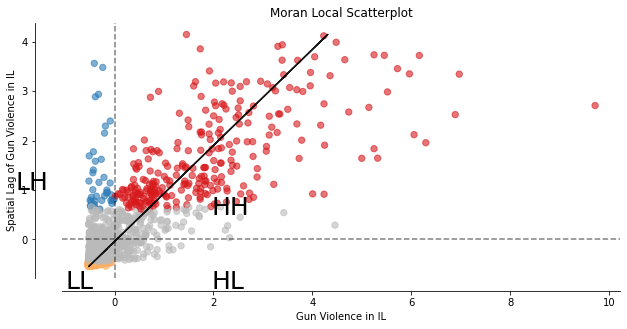

In [49]:
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Gun Violence in IL")
ax.set_ylabel('Spatial Lag of Gun Violence in IL')

plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

judging by the visualization, and the abundance of clusters, there is a high correlation proving the gun violence incidents are not located randomly

using the lisa_cluster function we can map the clusters

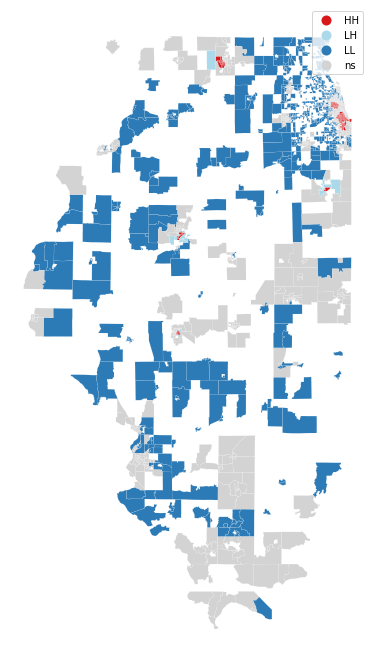

In [50]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, illinoisPop, p=0.05, ax=ax)
plt.show()

From this visualizations we see collections of LL areas and HH areas proving like areas surround like areas. However ther are some donuts of lower incident census tracts bordering higher incident areas. There are no diamonds in this collection.